In [ ]:
pip install gdown

In [ ]:
!gdown 15o4S0wTgEplPMLGFdHhnVIptGd5DVxcw

Downloading...
From (original): https://drive.google.com/uc?id=15o4S0wTgEplPMLGFdHhnVIptGd5DVxcw
From (redirected): https://drive.google.com/uc?id=15o4S0wTgEplPMLGFdHhnVIptGd5DVxcw&confirm=t&uuid=fa111d0c-bc60-4400-a6d7-6ba738ca1e68
To: /content/Copy of Copy of devnagari digit.zip
100% 16.6M/16.6M [00:00<00:00, 60.1MB/s]


In [ ]:
!unzip '/content/Copy of Copy of devnagari digit.zip'

Streaming output truncated to the last 5000 lines.
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10299.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10300.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10301.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10302.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10303.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10304.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10306.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10307.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104017.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104018.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104019.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104021.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104023.p

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image # Import Pillow

In [ ]:
# Define dataset paths
train_dir = "DevanagariHandwrittenDigitDataset/Train/"
test_dir = "DevanagariHandwrittenDigitDataset/Test/"

In [ ]:
# Define image size
img_height, img_width = 28, 28

In [ ]:
# Function to load images and labels using PIL
def load_images_from_folder(folder = "/content/DevanagariHandwrittenDigitDataset"):
  images = []
  labels = []
  class_names = sorted(os.listdir(folder)) # Sorted class names (digit_0, digit_1, ...)
  class_map = {name: i for i, name in enumerate(class_names)} # Map class names to labels
  for class_name in class_names:
    class_path = os.path.join(folder, class_name)
    label = class_map[class_name]
    for filename in os.listdir(class_path):
      img_path = os.path.join(class_path, filename)
# Load image using PIL
      img = Image.open(img_path).convert("L") # Convert to grayscale
      img = img.resize((img_width, img_height)) # Resize to (28,28)
      img = np.array(img) / 255.0 # Normalize pixel values to [0,1]
      images.append(img)
      labels.append(label)
  return np.array(images), np.array(labels)

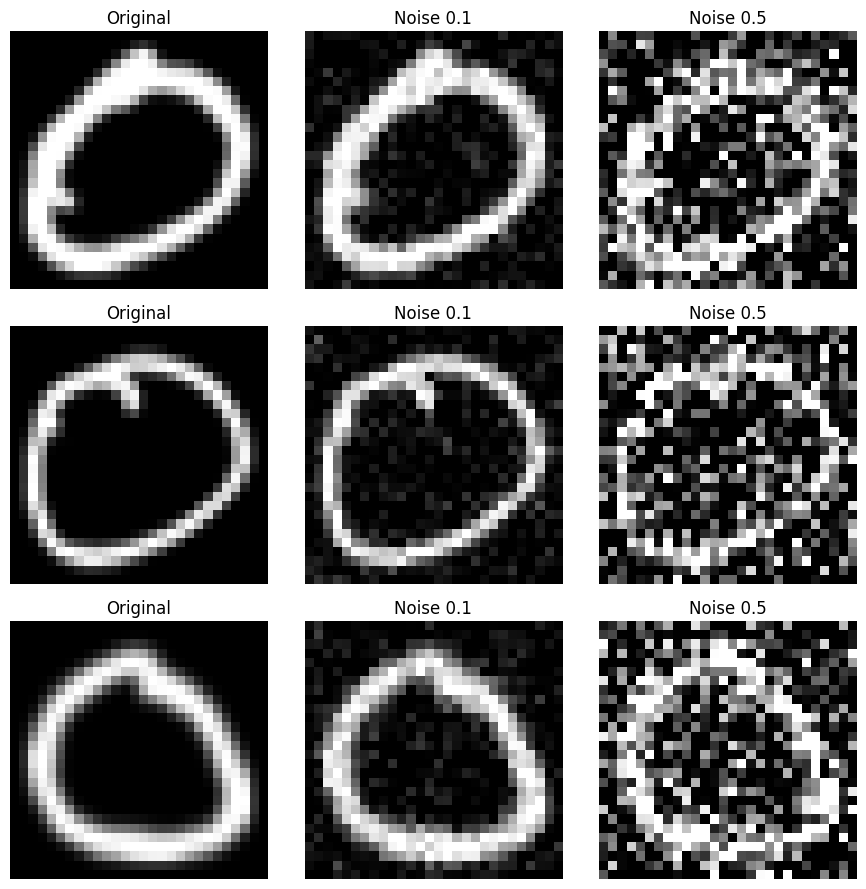

In [ ]:
# Load training and testing datasets
x_train, y_train = load_images_from_folder(train_dir)
x_test, y_test = load_images_from_folder(test_dir)
# Reshape images for Keras input
x_train = x_train.reshape(-1, img_height, img_width, 1) # Shape (num_samples, 28, 28, 1)
x_test = x_test.reshape(-1, img_height, img_width, 1)
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.
shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train
.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)
#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
# Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
x_train = x_train.reshape(-1, img_height, img_width, 1)

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_encoder(input_shape=(28, 28, 1)):
  """
  Builds the encoder part of the convolutional autoencoder.

  Parameters:
  input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.

  Returns:
  input_img (Keras Input): Input layer of the model.
  encoded (Keras Tensor): Encoded representation after convolution and pooling.
  """
  # Input layer
  input_img = Input(shape=input_shape, name="input")
  # Convolutional and pooling layers
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
  return input_img, encoded

def build_decoder(encoded_input):
  """
  Builds the decoder part of the convolutional autoencoder.

  Parameters:
  encoded_input (Keras Tensor): The output from the encoder.

  Returns:
  decoded (Keras Tensor): The reconstructed output after upsampling and convolution.
  """
  # Convolutional and upsampling layers
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  # Output layer
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
  return decoded

def build_autoencoder():
  """
  Constructs and compiles the full convolutional autoencoder by connecting encoder and decoder.

  Returns:
  autoencoder (Keras Model): Compiled autoencoder model.
  """
  input_img, encoded_output = build_encoder()
  decoded_output = build_decoder(encoded_output)
  # Create and compile the model
  autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
  autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
  return autoencoder

In [ ]:
def build_decoder(encoded_input):
  """
  Builds the decoder part of the convolutional autoencoder.
  Parameters:
  encoded_input (Keras Tensor): The output from the encoder.
  Returns:
  decoded (Keras Tensor): The reconstructed output after upsampling and
  convolution.
  """
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
  return decoded

In [ ]:
def build_autoencoder():
  """
  Constructs and compiles the full convolutional autoencoder by connecting encoder and
  decoder.
  Returns:
  autoencoder (Keras Model): Compiled autoencoder model.
  """
  input_img, encoded_output = build_encoder()
  decoded_output = build_decoder(encoded_output)
  autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
  autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
  return autoencoder

In [ ]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded (MaxPooling2D)               │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoded (Conv2D)                     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
x_train_noisy_high, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 415ms/step - loss: 0.4158 - val_loss: 0.2148
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 380ms/step - loss: 0.2111 - val_loss: 0.2004
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 84s 400ms/step - loss: 0.1992 - val_loss: 0.1955
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 79s 376ms/step - loss: 0.1950 - val_loss: 0.1922
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 385ms/step - loss: 0.1922 - val_loss: 0.1898
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - loss: 0.1900 - val_loss: 0.1884
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 80s 377ms/step - loss: 0.1884 - val_loss: 0.1870
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 375ms/step - loss: 0.1870 - val_loss: 0.1859
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 378ms/step - loss: 0.1860 - val_loss: 0.1850
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 381ms/step - loss: 0.1852 - val_loss: 0.1844


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


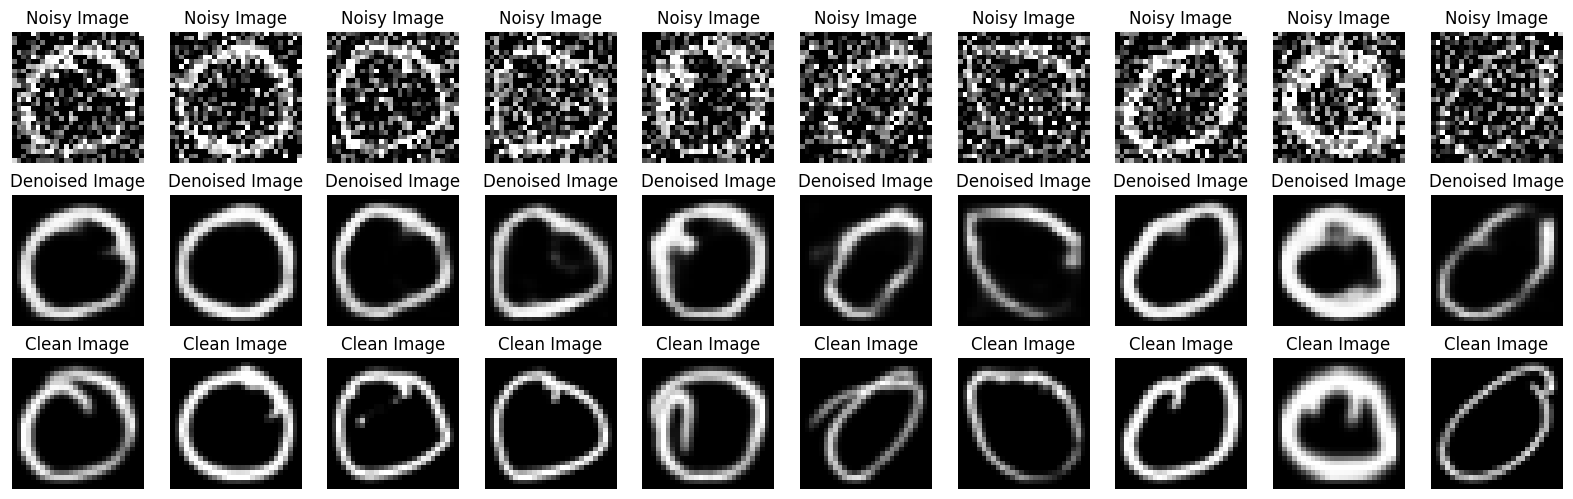

In [ ]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
  plt.figure(figsize=(20, 6))
  for i in range(n):
    # Plot noisy images
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    # Plot denoised images
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')
    # Plot clean images
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
    plt.title("Clean Image")
    plt.axis('off')
  plt.show()
# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)